<a href="https://colab.research.google.com/github/Swathi1309/ED18B034_ME18B133_CS6910/blob/main/Assignment3/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout, TimeDistributed, Lambda, Activation, Reshape,\
Softmax, Multiply, AdditiveAttention, Concatenate, Add, RepeatVector
import tarfile
import random
from keras.optimizers import RMSprop, Adam, SGD

In [ ]:
!pip install wandb
!wandb login
import wandb
from wandb.keras import WandbCallback
wandb.init(project="CS6910-assg3", entity="narendv")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Examples

Loading Data

In [ ]:
my_tar = tarfile.open('/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0.tar')
my_tar.extractall('/content/drive/MyDrive/Dakshina dataset') # specify which folder to extract to
my_tar.close()

Examples

In [ ]:
import csv
hi_to_eng = open("/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv")
read_tsv = csv.reader(hi_to_eng, delimiter="\t")
i=0
for row in read_tsv:
  i +=1
  print(row)
  if i==30:
    break
hi_to_eng.close()

In [ ]:
  # Number of samples to train on.
# Path to the data txt file on disk.
data_path_train = "/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
data_path_dev = '/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv'

In [ ]:
def load_inputs(data_path,data):
  # Vectorize the data.
  input_texts = []
  target_texts = []
  input_characters = set()
  target_characters = set()
  with open(data_path, "r", encoding="utf-8") as f:
      lines = f.read().split("\n")
  for line in lines[: (len(lines) - 1)]:
      input_text, target_text, _ = line.split("\t")
      # We use "tab" as the "start sequence" character for the targets, and "\n" as "end sequence" character.
      target_text = "\t" + target_text + "\n"
      input_texts.append(input_text)
      target_texts.append(target_text)
      for char in input_text:
          if char not in input_characters:
              input_characters.add(char)
      for char in target_text:
          if char not in target_characters:
              target_characters.add(char)

  input_characters = sorted(list(input_characters))
  target_characters = sorted(list(target_characters))
  num_encoder_tokens = len(input_characters)
  num_decoder_tokens = len(target_characters)
  global max_encoder_seq_length, max_decoder_seq_length
  if data == 'train':
    max_encoder_seq_length = max([len(txt) for txt in input_texts])
    max_decoder_seq_length = max([len(txt) for txt in target_texts])

  # print("Number of samples:", len(input_texts))
  # print("Number of unique input tokens:", num_encoder_tokens)
  # print("Number of unique output tokens:", num_decoder_tokens)
  # print("Max sequence length for inputs:", max_encoder_seq_length)
  # print("Max sequence length for outputs:", max_decoder_seq_length)

  input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
  target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])
  if data == 'train':
    encoder_input_data = np.zeros(
        (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
    )
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
    )
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
    )
  if data == 'dev':
    encoder_input_data = np.zeros(
        (len(input_texts), max_encoder_seq_length, input_token_train), dtype="float32"
    )
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, output_token_train), dtype="float32"
    )
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, output_token_train), dtype="float32"
    )
  
  random.seed(0)
  temp = list(zip(input_texts, target_texts))
  random.shuffle(temp)
  
  for i, (input_text, target_text) in enumerate(temp):
      for t, char in enumerate(input_text):
          encoder_input_data[i, t, input_token_index[char]] = 1.0
      # encoder_input_data[i, (t + 1):, input_token_index[" "]] = 1.0
      for t, char in enumerate(target_text):
          # decoder_target_data is ahead of decoder_input_data by one timestep
          decoder_input_data[i, t, target_token_index[char]] = 1.0
          if t > 0:
              # decoder_target_data will be ahead by one timestep
              # and will not include the start character.
              decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
      # decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
      # decoder_target_data[i, t:, target_token_index[" "]] = 1.0

  return encoder_input_data, decoder_input_data, decoder_target_data, num_encoder_tokens, num_decoder_tokens, temp

In [ ]:
global enc_input_train, dec_input_train, dec_target_train, input_token_train, output_token_train #, input_token_index, target_token_index
global enc_input_dev, dec_input_dev, dec_target_dev
enc_input_train, dec_input_train, dec_target_train, input_token_train, output_token_train, zipped_list = load_inputs(data_path_train,'train')
enc_input_dev, dec_input_dev, dec_target_dev, _, _, _ = load_inputs(data_path_dev,'dev')

# Loading

In [15]:
def load_data(data_path, data):
  input_texts=[]
  target_texts = []
  global tk_input, tk_target, num_input_tokens, num_target_tokens
  
  with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
  for line in lines[: (len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
     
  if (data == "train"):
    tk_input = keras.preprocessing.text.Tokenizer(num_words=None, char_level=True)
    tk_input.fit_on_texts(input_texts)
    enc_input = tk_input.texts_to_sequences(input_texts)
    enc_input = tf.keras.preprocessing.sequence.pad_sequences(enc_input, padding='post')

    tk_target = keras.preprocessing.text.Tokenizer(num_words=None, char_level=True)
    tk_target.fit_on_texts(target_texts)
    dec_target = tk_target.texts_to_sequences(target_texts)
    dec_target = tf.keras.preprocessing.sequence.pad_sequences(dec_target, padding='post')

    dec_input = np.zeros(dec_target.shape)
    dec_input[:,:(dec_target.shape[1]-1)] = dec_target[:,1:]
  
  else:
    enc_input = tk_input.texts_to_sequences(input_texts)
    enc_input = tf.keras.preprocessing.sequence.pad_sequences(enc_input, padding='post', maxlen = max_input_length)

    dec_target = tk_target.texts_to_sequences(target_texts)
    dec_target = tf.keras.preprocessing.sequence.pad_sequences(dec_target, padding='post', maxlen = max_target_length)

    dec_input = np.zeros(dec_target.shape)
    dec_input[:,:(dec_target.shape[1]-1)] = dec_target[:,1:]
  
  return enc_input, dec_target, dec_input

In [16]:
global enc_input_train, dec_input_train, dec_target_train, enc_input_dev, dec_input_dev, dec_target_dev
global tk_input, tk_target
global input_token_train, output_token_train, max_input_length, max_target_length

batch_size = 256

enc_input_train, dec_input_train, dec_target_train = load_data(data_path_train,'train')

max_input_length = enc_input_train.shape[1]
max_target_length = dec_target_train.shape[1]

num_input_tokens = len(tk_input.word_index)+1
num_target_tokens = len(tk_target.word_index)+1

enc_input_dev, dec_input_dev, dec_target_dev = load_data(data_path_dev,'dev')

In [ ]:
list(zipped_list)[0:10]

In [8]:
def encoder(enc_out,enc_block, latent_dim, enc_layers):
  states = []
  for i in range(0,enc_layers):
    if enc_block =='LSTM':
      enc_out ,h ,c = LSTM(latent_dim, return_state=True, return_sequences=True, name='encoder'+str(i))(enc_out)
      s = [h,c]
      states.append(s)
    elif enc_block =='GRU':
      enc_out ,s = GRU(latent_dim, return_state=True, return_sequences=True, name='encoder'+str(i))(enc_out)
      states.append(s)
    else:
      enc_out ,s = SimpleRNN(latent_dim, return_state=True, return_sequences=True, name='encoder'+str(i))(enc_out)
      states.append(s)
    
  return enc_out,states

# Attention model

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [94]:
def b_attention(latent_dim):

  query_in = keras.Input((latent_dim,))
  values_in = keras.Input((max_input_length,latent_dim))
  query = Reshape((1,latent_dim), name='query_reshape')(query_in)
  score_unit2 = Dense(num_target_tokens, name='score_unitq')(query)
  score_unit1 = Dense(num_target_tokens, name='score_unitv')(values_in)
  score_unit12 = Add()([score_unit1, score_unit2])
  score_unit12 = Activation('tanh')(score_unit12)
  score = Dense(1)(score_unit12)
  attention_weights = Softmax(axis=1)(score)
  context_vector = Multiply()([attention_weights,values_in])
  context_vector = Lambda(lambda x: tf.reduce_sum(x,axis=1))(context_vector)
  context_vector = RepeatVector(max_target_length)(context_vector)

  model = Model(inputs = [query_in,values_in], outputs = [context_vector, attention_weights], name='Attention')
  return model

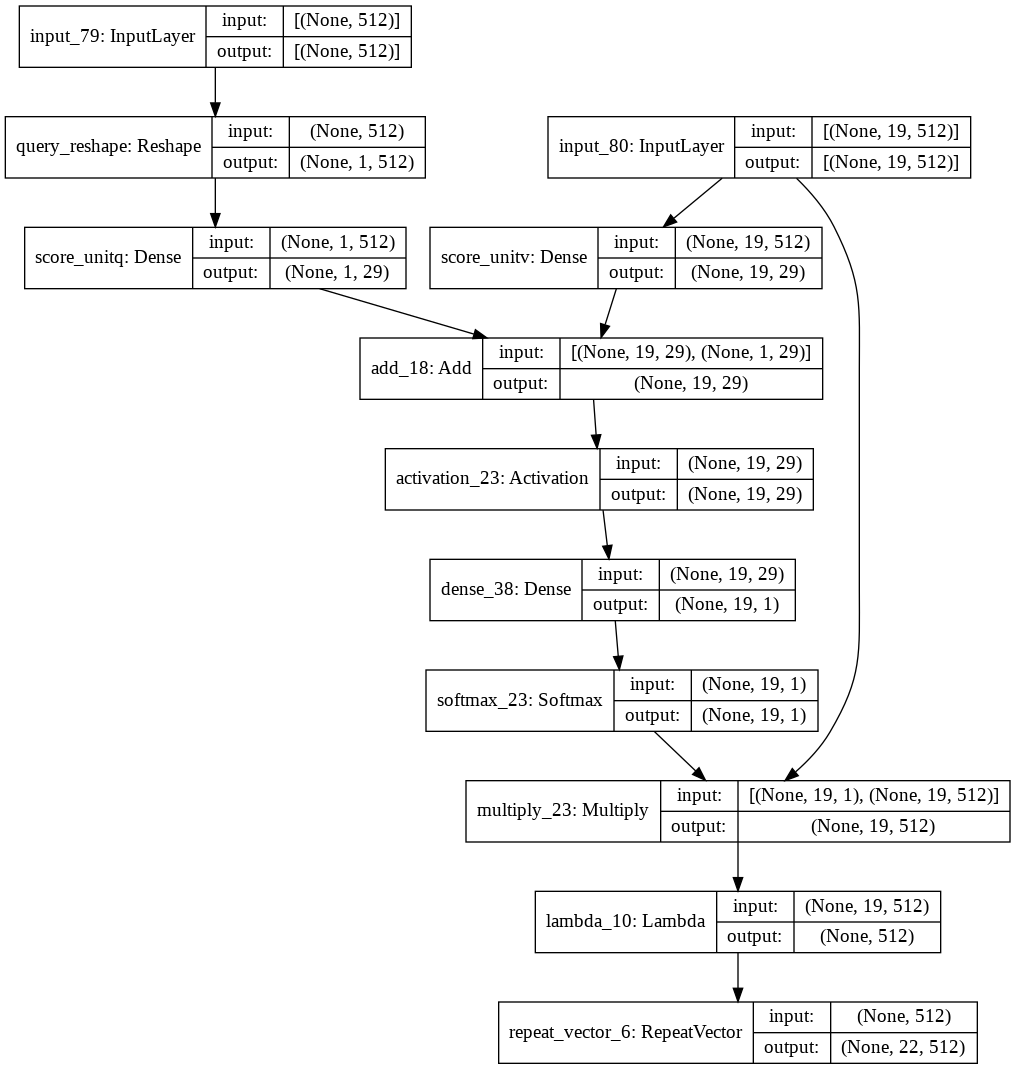

In [95]:
# query = tf.random.normal((256,512))
# values = tf.random.normal((256,19,512))
model = b_attention(512)
keras.utils.plot_model(model,show_shapes=True, rankdir='TB')

# Rest of the code

In [9]:
def decoder(X_input_dec, hs_init, latent_dim, dec_block, dec_layers, dense_no, drop_no):
  out_dec = X_input_dec
  hs = hs_init
  for i in range (0,dec_layers):
    if dec_block == 'LSTM':
      out_dec, h, s = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder'+str(i))(out_dec, initial_state = hs[i])
      # hs = [h,s]
    elif dec_block == 'GRU':
      out_dec, _ = GRU(latent_dim, return_sequences=True, return_state=True, name='decoder'+str(i))(out_dec, initial_state = hs[i])
    else:
      out_dec, _ = SimpleRNN(latent_dim, return_sequences=True, return_state=True, name='decoder'+str(i))(out_dec, initial_state = hs[i])
  
  # out_dec = Dense(dense_no/2, activation='tanh')(out_dec)
  # out_dec = Dropout(drop_no)(out_dec)
  out_dec = TimeDistributed(Dense(num_target_tokens, activation="softmax"))(out_dec)
  

  return out_dec

In [10]:
def RNN_model(embedding_no, enc_block, latent_dim, dec_block, dense_no, drop_no, enc_layers, dec_layers):
  X_input_enc = keras.Input(shape=(max_input_length,))
  X_input_dec = keras.Input(shape=(max_target_length,))
  X_enc = tf.keras.layers.Embedding(num_input_tokens, embedding_no, name = 'embedding_enc')(X_input_enc)
  X_dec = tf.keras.layers.Embedding(num_target_tokens, embedding_no, name = 'embedding_dec')(X_input_dec)
  _,s_init = encoder(X_enc,enc_block, latent_dim, enc_layers)
  out_dec = decoder(X_dec,s_init, latent_dim, dec_block, dec_layers, dense_no, drop_no)
  model = Model(inputs = [X_input_enc,X_input_dec], outputs = out_dec, name = 'train_model')
  return model

In [89]:
def RNN_w_att(embedding_no, enc_block, latent_dim, dec_block, dense_no, drop_no, enc_layers, dec_layers):
  X_input_enc = keras.Input(shape=(max_input_length,))
  X_input_dec = keras.Input(shape=(max_target_length,))

  X_enc = tf.keras.layers.Embedding(num_input_tokens, embedding_no, name = 'embedding_enc')(X_input_enc)
  X_dec = tf.keras.layers.Embedding(num_target_tokens, embedding_no, name = 'embedding_dec')(X_input_dec)

  values,s_init = encoder(X_enc,enc_block, latent_dim, enc_layers)
  # print(tf.shape(values))
  # print(tf.shape(s_init[len(s_init)-1][0]))
  context_vector, weights = b_attention(latent_dim)([s_init[len(s_init)-1][0], values])
  X_dec = Concatenate()([context_vector,X_dec])

  out_dec = decoder(X_dec,s_init, latent_dim, dec_block, dec_layers, dense_no, drop_no)
  model = Model(inputs = [X_input_enc,X_input_dec], outputs = out_dec, name = 'train_model')

  return model

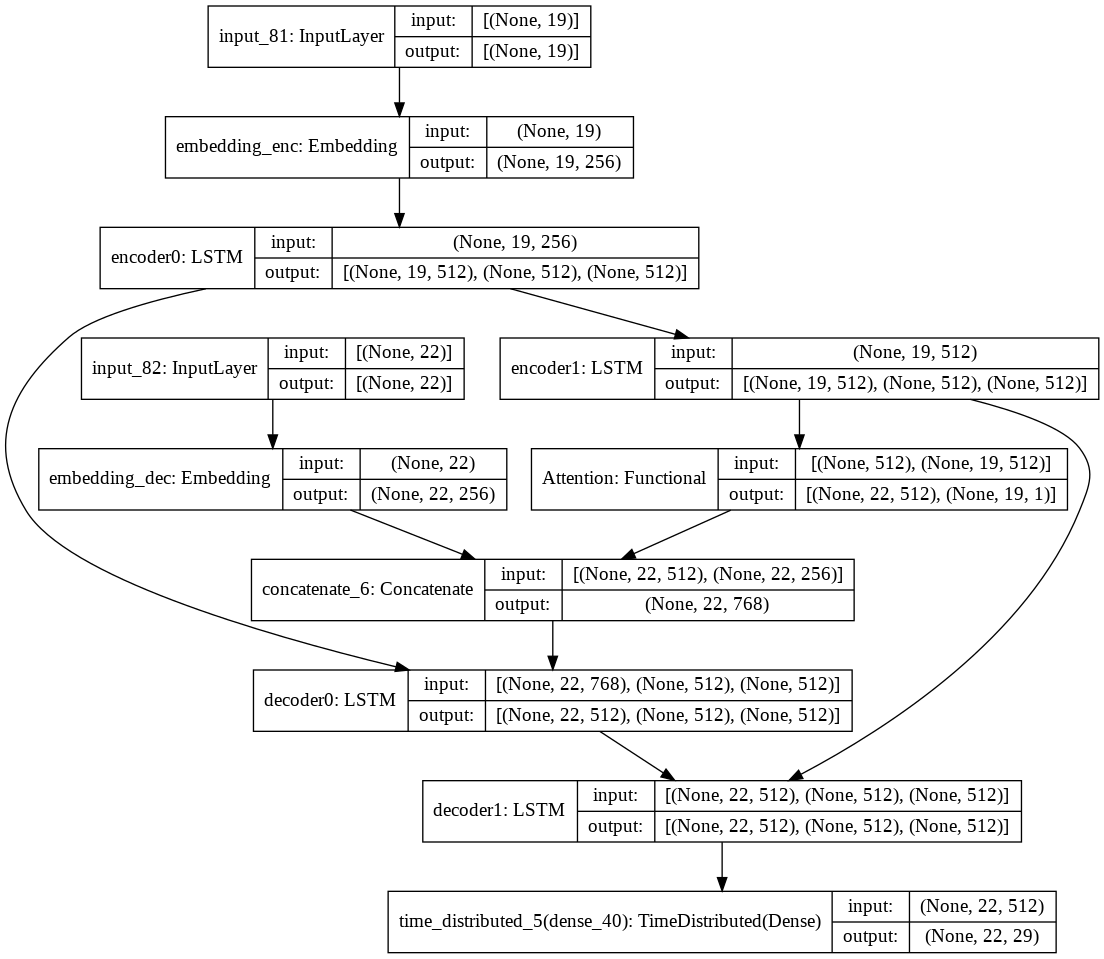

In [96]:
model = RNN_w_att(256, 'LSTM', 512, 'LSTM', 256, 0, 2, 2)
keras.utils.plot_model(model,show_shapes=True, rankdir='TB')

In [97]:
from keras.utils import to_categorical
y_true_dev = np.zeros((dec_target_dev.shape[0],dec_target_dev.shape[1], num_target_tokens))
for i in range(0,dec_target_dev.shape[0]):
  y_true_dev[i] = to_categorical(dec_target_dev[i], num_classes = num_target_tokens)
print(y_true_dev.shape)

y_true_train = np.zeros((dec_target_train.shape[0],dec_target_train.shape[1], num_target_tokens))
for i in range(0,dec_target_train.shape[0]):
  y_true_train[i] = to_categorical(dec_target_train[i], num_classes = num_target_tokens)
print(y_true_train.shape)

(4358, 22, 29)
(44204, 22, 29)


In [ ]:
print(dec_target_train[0])
print(y_true_train[0])

In [23]:
def word_accuracy(y_true,y_pred):
  acc = tf.cast(tf.math.reduce_all(tf.math.reduce_all(tf.equal(y_pred,y_true),-1),-1),dtype=tf.int32)
  return tf.reduce_sum(acc)/tf.shape(y_true)[0]

In [98]:
model.compile(optimizer=Adam(1e-2), loss = 'categorical_crossentropy', metrics=['accuracy', word_accuracy])
model.fit([enc_input_train,dec_input_train], y_true_train,
            batch_size = 128,epochs=10, validation_data=([enc_input_dev,dec_input_dev], y_true_dev))

Epoch 1/10
346/346 [==============================] - 51s 125ms/step - loss: 1.2322 - accuracy: 0.6918 - word_accuracy: 0.0000e+00 - val_loss: 0.6904 - val_accuracy: 0.7988 - val_word_accuracy: 0.0000e+00
Epoch 2/10
346/346 [==============================] - 41s 120ms/step - loss: 0.6856 - accuracy: 0.7973 - word_accuracy: 0.0000e+00 - val_loss: 0.5847 - val_accuracy: 0.8272 - val_word_accuracy: 0.0000e+00
Epoch 3/10
346/346 [==============================] - 42s 120ms/step - loss: 0.5581 - accuracy: 0.8346 - word_accuracy: 0.0000e+00 - val_loss: 0.3477 - val_accuracy: 0.8991 - val_word_accuracy: 0.0000e+00
Epoch 4/10
346/346 [==============================] - 41s 120ms/step - loss: 0.3165 - accuracy: 0.9052 - word_accuracy: 0.0000e+00 - val_loss: 0.2296 - val_accuracy: 0.9302 - val_word_accuracy: 0.0000e+00
Epoch 5/10
346/346 [==============================] - 41s 120ms/step - loss: 0.2185 - accuracy: 0.9329 - word_accuracy: 0.0000e+00 - val_loss: 0.1932 - val_accuracy: 0.9410 - val_w

In [66]:
def enc_inference(model,enc_layers):
  X_enc = model.input[0]
  X_in_enc = model.get_layer('embedding_enc')(X_enc)
  enc_outputs = X_in_enc
  states = []
  for i in range(0,enc_layers):
    enc_outputs, h_enc, s_enc = model.get_layer('encoder'+str(i))(enc_outputs)
    states.append([h_enc, s_enc])
  enc_model = keras.Model(inputs = X_enc, outputs = states)

  return enc_model

def dec_inference(model, latent_dim, dec_layers):
  dec_inputs = model.input[1]
  # print(tf.shape(dec_inputs))
  dec_outputs = model.get_layer('embedding_dec')(dec_inputs)
  hs_inputs = []
  for i in range(0,dec_layers):
    h = keras.Input(shape=(latent_dim,))
    c = keras.Input(shape=(latent_dim,))
    hs_inputs.append([h,c])
  hs_outputs = []
  for i in range(0,dec_layers):
    dec_outputs, h_dec, s_dec = model.get_layer('decoder'+str(i))(dec_outputs, initial_state = hs_inputs[i])
    hs_outputs.append([h_dec,s_dec])
  dec_dense = model.layers[-1]
  dec_outputs = dec_dense(dec_outputs)
  dec_model = keras.Model(inputs = [dec_inputs] + hs_inputs, outputs = [dec_outputs] + hs_outputs)
  
  return dec_model

reverse_input_char_index = dict((i, char) for char, i in tk_input.word_index.items())
reverse_target_char_index = dict((i, char) for char, i in tk_target.word_index.items())

def decode_sequence(input_seq, encoder_model, decoder_model):
    # Encode the input as state vectors.
    states_values = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, max_target_length))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = tk_target.word_index["\t"]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    # i = 0
    decoded_sentence = ""
    while True:
      # i += 1
      # print(i)
      output_tokens, s_list = decoder_model.predict([target_seq] + states_values)
      # Sample a token
      sampled_token_index = np.argmax(output_tokens[0, 0, :])
      print(sampled_token_index)
      if sampled_token_index == 0 or len(decoded_sentence) > max_target_length :
          return decoded_sentence
      sampled_char = reverse_target_char_index[sampled_token_index]
      decoded_sentence += sampled_char

      # Exit condition: either hit max length
      # or find stop character.


      # Update the target sequence (of length 1).
      target_seq = np.zeros((1, max_target_length))
      target_seq[0, 0] = sampled_token_index

      # Update states
      states_value = s_list
    return decoded_sentence

In [67]:
def predict(model,latent_dim,enc_layers, dec_layers):
  enc_block = enc_inference(model, enc_layers)
  dec_block = dec_inference(model,latent_dim, dec_layers)
  # keras.utils.plot_model(dec_block,show_shapes=True)
  #input_seq = tf.expand_dims(enc_input_dev[10],0)
  input_seq = tf.expand_dims(enc_input_dev[0], 0)
  decoded_word = decode_sequence(input_seq, enc_block, dec_block)

  return decoded_word

In [68]:
predict(model,512,1,1)

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


'\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t'

In [ ]:
import pprint

In [ ]:
sweep_config = {
    'method': 'grid'
    }

parameters_dict = {
    'encoder_block':{
        'values': ['LSTM']
      },
    # 'encoder_layers': {
    #     'values': [1,2,3]
    #   },
    'decoder_block':{
      'values' : ['LSTM']
      },
    # 'decoder_layers': {
    #     'values': [1,2,3]
    #   },
    'latent_dimension': {
        'values': [256]
      },
    'hidden_layer': {
        'values': [128]
      },
    'dropout': {
        'values': [0]
      },
    'epochs' : {
        'values' : [60]
    }
}

sweep_config['parameters'] = parameters_dict
pprint.pprint(sweep_config)

def training_sweep(config=None):
    with wandb.init(config=config):
        print(input_token_train)
        config = wandb.config
        print(output_token_train)
        model = RNN_model(input_token_train, config.encoder_block, config.latent_dimension, output_token_train, config.decoder_block,  config.hidden_layer, config.dropout)
        print('lol')
        model.compile(optimizer='rmsprop', loss = 'categorical_crossentropy', metrics='accuracy')
        print('lol')
        history = model.fit([enc_input_train,dec_input_train], dec_target_train, 
                            epochs=config.epochs,
                            validation_data = ([enc_input_dev,dec_input_dev], dec_target_dev),
                            callbacks = [WandbCallback()]
                            )
        print('lol')
        name = str(config.encoder_block) + '_' + str(config.encoder_layers) + '_' + str(config.decoder_block) + '_' + str(config.decoder_layers) + '_' + str(config.hidden_layer) + '_' + str(config.dropout) + '_' + str(config.epochs)
        location = '/content/drive/MyDrive/Transliteration/' + name
        model.save(location)

{'method': 'grid',
 'parameters': {'decoder_block': {'values': ['LSTM']},
                'dropout': {'values': [0]},
                'encoder_block': {'values': ['LSTM']},
                'epochs': {'values': [60]},
                'hidden_layer': {'values': [128]},
                'latent_dimension': {'values': [256]}}}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="CS6910-assg3")
wandb.agent(sweep_id, training_sweep)